## Read Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

df = pd.read_csv('../data/seeds.csv')
df.head()

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## EDA

### Scatter

/home/mehdi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


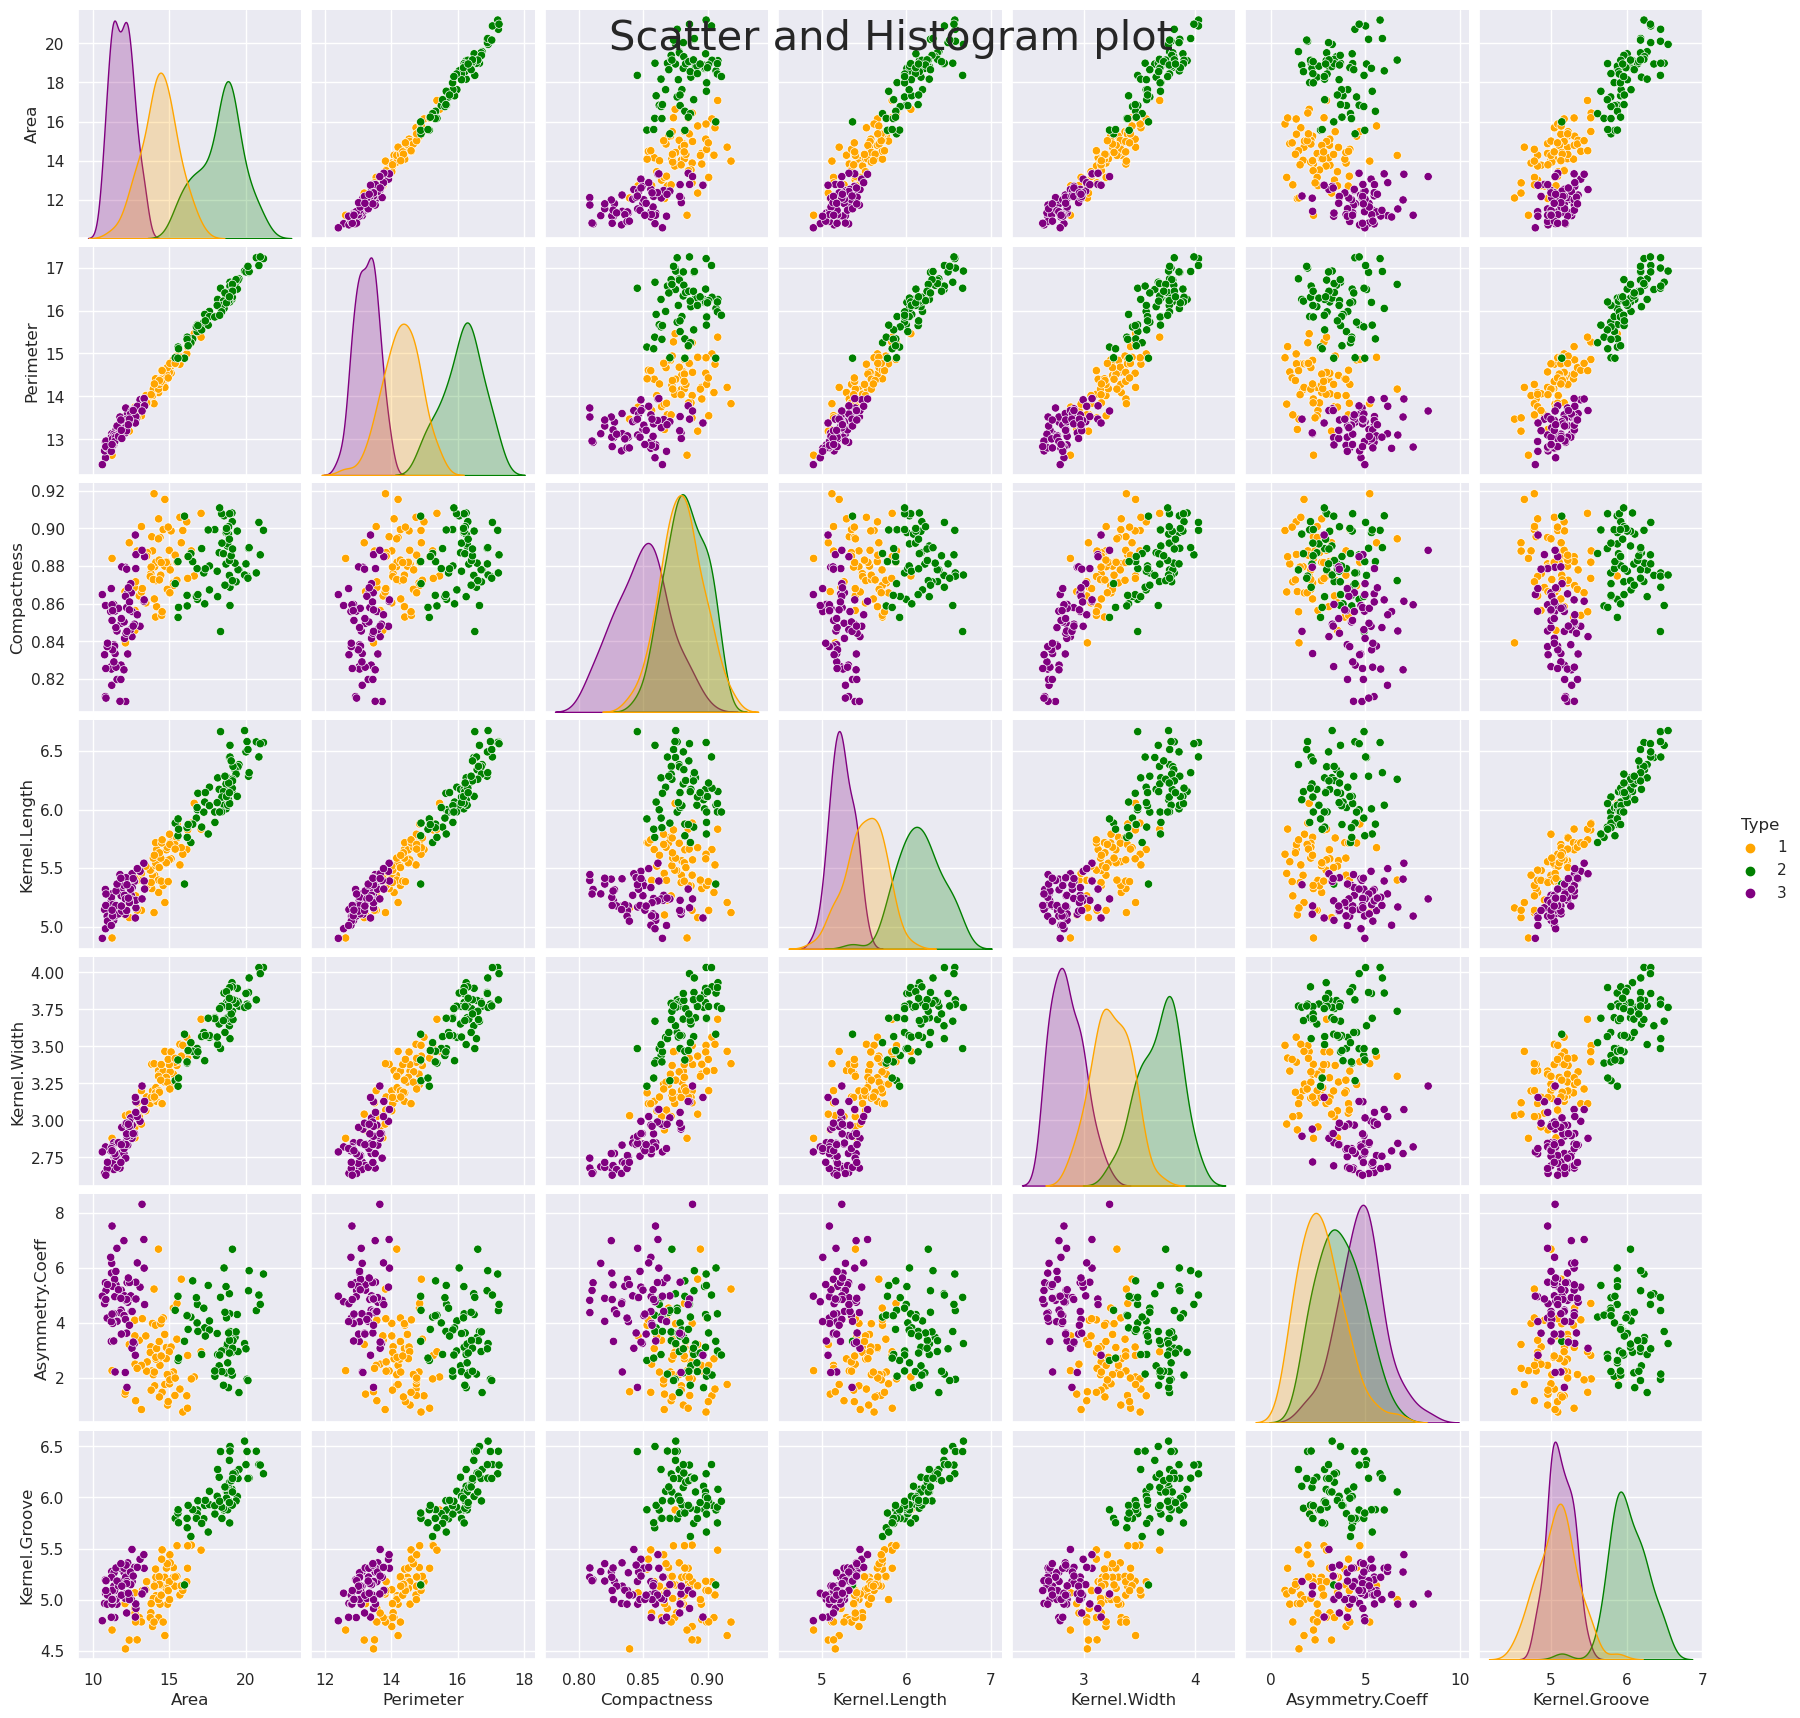

In [3]:
palette = {1: 'orange', 2: 'green', 3: 'purple'}
g = sns.pairplot(df, vars = df.columns[0:7], hue="Type", palette=palette)
plt.suptitle('Scatter and Histogram plot', fontsize=30)

plt.savefig('../assets/Q8_EDA.png')
plt.show()

## Preprocessing & Normalization

In [4]:
def normalize(df):
    for feature in df.select_dtypes([int, float]).columns:
        df.loc[:, feature] = (df[feature] - df[feature].mean()) / df[feature].std()
    return df

In [5]:
target = 'Type' 
X= df.drop(target, axis=1)
y = df[target]
X = normalize(X)
X.head()

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove
0,0.116870,0.186327,0.008124,0.270178,0.122825,-1.004836,-0.407238
1,-0.013269,-0.019710,0.441229,-0.200974,0.178333,-1.822590,-0.943041
2,-0.215325,-0.385998,1.466100,-0.793859,0.188906,-0.679910,-1.208914
3,-0.369436,-0.500463,1.058724,-0.719467,0.299923,-0.979005,-1.249505
4,0.418242,0.300792,1.397490,0.033475,0.783638,-1.593511,-0.498568


## Classification

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=42)

In [7]:
class LogisticRegression:
    def __init__(self, learning_rate=1.e-4, tolerance=0.03, initial_weights=None) -> None:
        self.initial_weights = initial_weights
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.weights = None

    def fit(self, X, y_true):
        X = self._add_bias(X)
        y_unique = np.unique(y)
        
        if self.initial_weights == None:
            self.initial_weights = np.ones(X.shape[1]) / 2
        self.weights = np.repeat(np.atleast_2d(self.initial_weights), len(y_unique), axis=0)

        for i in range(len(y_unique)): 
            y_onevsall = np.where(y_true == y_unique[i], 1, 0)
            self.weights[i] = self._gradient_descent(X, y_onevsall, self.weights[i])

        return self
    
    def predict(self, X):
        X = self._add_bias(X)
        return np.array([np.argmax(self._sigmoid_function(np.dot(self.weights, x))) for x in X])
    
    def _gradient_descent(self, X, y_true, initial_weights):
        weights = initial_weights
        gradient_length = np.inf

        while gradient_length > self.tolerance:

            errors = self._sigmoid_function(np.dot(X, weights)) - y_true 
            gradient = self._gradient(X, errors)
            weights -= self.learning_rate * gradient

            gradient_length = np.linalg.norm(gradient)
        return weights
    
    def _gradient(self, X, errors):
        return np.sum(X * errors.reshape(-1, 1), axis=0) / len(X)
    
    def _sigmoid_function(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)
    

In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Evaluation

In [9]:
class Metrics:
    def confusion_matrix(y_true, y_pred):
        y_unique = np.unique(y_true)
        num_class = len(y_unique)
        cm = np.zeros((num_class, num_class), dtype=int)
        for i in range(num_class):
            for j in range(num_class):
                cm[i, j] = np.sum(np.where(y_true == y_unique[i], 1, 0) * np.where(y_pred == y_unique[j], 1, 0))
        return cm
    
    def accuracy(y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)
    
    def precision(y_true, y_pred):
        cm = Metrics.confusion_matrix(y_true, y_pred)
        return cm.diagonal() / np.sum(cm, axis=0)
    
    def recall(y_true, y_pred):
        cm = Metrics.confusion_matrix(y_true, y_pred)
        return cm.diagonal() / np.sum(cm, axis=1)
    
    def f1_score(y_true, y_pred):
        precision = Metrics.precision(y_true, y_pred)
        recall = Metrics.recall(y_true, y_pred)
        return 2 * precision * recall / (precision + recall)
    
    def macro_avg(metrics):
        return np.sum(metrics) / len(metrics)
    
    def weighted_avg(metrics, weights):
        return np.dot(metrics, weights) / sum(weights)
    
    def classification_report(y_true, y_pred, labels):
        precision = Metrics.precision(y_true, y_pred)
        recall = Metrics.recall(y_true, y_pred)
        f1_score = Metrics.f1_score(y_true, y_pred)

        accuracy = Metrics.accuracy(y_true, y_pred)

        precision_macro = Metrics.macro_avg(precision)
        recall_macro = Metrics.macro_avg(recall)
        f1_score_macro = Metrics.macro_avg(f1_score)

        _, weights = np.unique(y_true, return_counts=True)
        
        precision_avg = Metrics.weighted_avg(precision, weights)
        recall_avg = Metrics.weighted_avg(recall, weights)
        f1_score_avg = Metrics.weighted_avg(f1_score, weights)

        print(f"{'': <13} {'precision': <12} {'recall': <7} {'f1-score'}", end='\n\n')
        for i in range(len(labels)):
            print(f"{labels[i]: >12} {precision[i]: >10.2f} {recall[i]: >9.2f} {f1_score[i]:>9.2f}")
        print()
        print(f"{'accuracy': >12} {accuracy:>30.2f}")
        print(f"{'macro avg': >12} {precision_macro: >10.2f} {recall_macro: >9.2f} {f1_score_macro:>9.2f}")
        print(f"{'weighted avg': >8} {precision_avg: >10.2f} {recall_avg: >9.2f} {f1_score_avg:>9.2f}")


    def plot_confusion_matrix(y_true, y_pred, labels):
        cm = Metrics.confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        

In [10]:
Metrics.classification_report(y_test, y_pred + 1, ['Type 1', 'Type 2', 'Type 3'])

              precision    recall  f1-score

      Type 1       0.71      0.56      0.63
      Type 2       0.95      1.00      0.97
      Type 3       0.77      0.83      0.80

    accuracy                           0.85
   macro avg       0.81      0.80      0.80
weighted avg       0.84      0.85      0.84


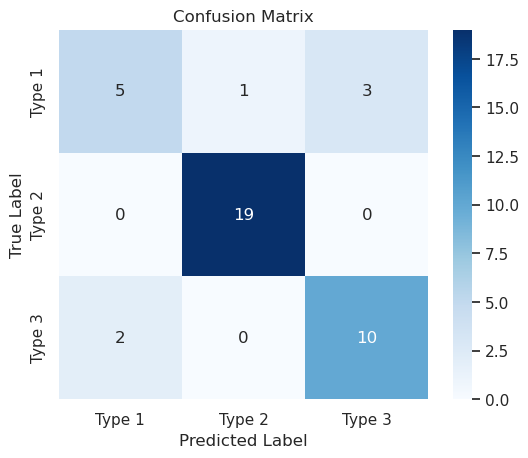

In [11]:
Metrics.plot_confusion_matrix(y_test, y_pred + 1, ['Type 1', 'Type 2', 'Type 3'])
plt.savefig('../assets/Q8_cm.png')
plt.show()

## KNN Classifier

In [12]:
class KNN:
    def __init__(self, k):
        self.k = k
        self.X = None
        self.y_true = None

    def fit(self, X, y_true):
        self.X = X
        self.y_true = y_true

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            distances = np.linalg.norm(self.X - X[i], axis=1)
            neighbors = list(zip(distances, self.y_true))
            knn = sorted(neighbors, key=lambda x: x[0])[:self.k]
            pred = np.bincount([neighbor[1] for neighbor in knn]).argmax()
            y_pred.append(pred.item())
        return y_pred

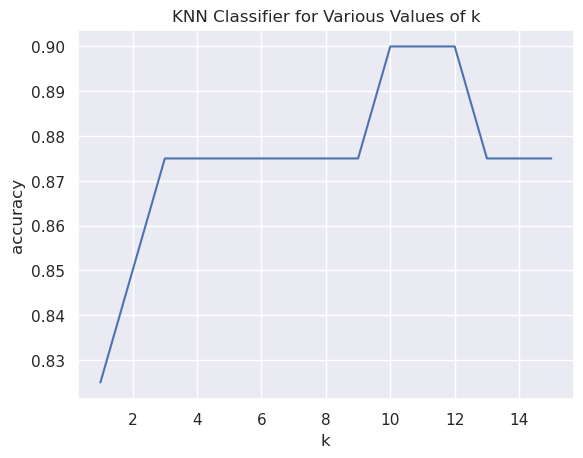

In [13]:
max_k = 15
accuracies = []
for k in range(1, max_k + 1):
    model = KNN(k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(Metrics.accuracy(y_test, y_pred))

plt.plot(range(1, max_k + 1), accuracies)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('KNN Classifier for Various Values of k')
plt.savefig('../assets/Q8_knn.png')
plt.show()